In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, features

pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")

In [38]:
df = my_modules.preprocessing(df)
df = my_modules.common_process(df)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 75 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              252411 non-null  int64         
 1   year                 252411 non-null  int64         
 2   month                252411 non-null  int64         
 3   day                  252411 non-null  int64         
 4   times                252411 non-null  int64         
 5   place                252411 non-null  object        
 6   daily                252411 non-null  object        
 7   race_num             252411 non-null  int64         
 8   horse                252411 non-null  object        
 9   jockey_id            252411 non-null  object        
 10  trainer_id           252411 non-null  int64         
 11  horse_N              252411 non-null  object        
 12  waku_num             252411 non-null  int64         
 13  horse_num          

### Elo Ratingの計算

In [40]:
from itertools import combinations
from collections import defaultdict

def calc_elo_rating(df_to_copy, feature_col, K=32, target_col=None, prefix=None):
    if (target_col is None) or (prefix is None):
        raise ValueError("target_col and prefix must be specified")

    df = df_to_copy.copy()
    feature_col = feature_col.copy()
    df[f"{prefix}_EloRating"] = np.nan
    df[f"{prefix}_EloRating_after_racing"] = np.nan

    feature_col.append(f"{prefix}_EloRating") #　レース前EloRatingのみを追加

    ratings = defaultdict(lambda: 1500)  # レート保存用辞書

    grouped = df.groupby("id_for_fold", observed=True)
    
    for id, group in grouped:
        if len(group) < 2: # レース出走馬が2頭以下なら処理をスキップ
            continue
        race_data = group[group["error_code"] == 0].copy()
        horse_list = race_data[target_col].tolist()
        ranks = race_data["rank"].tolist()

        # レース前レートを記録
        all_horse_list = group[target_col].tolist()
        elo_array = [ratings[horse] for horse in all_horse_list]
        mask = (df["id_for_fold"] == id) & (df[target_col].isin(all_horse_list))
        df.loc[mask, f"{prefix}_EloRating"] = elo_array

        delta = defaultdict(float) # 差分を保存する関数
        K_modified = K / (len(race_data) - 1) # 総和が0になるようにKの値を調整

        # 各ペアについて期待勝率・実際の勝敗を計算
        for i, j in combinations(range(len(race_data)), 2): # ← ペアは一度だけ
            hi, hj = horse_list[i], horse_list[j]
            Ri, Rj = ratings[hi], ratings[hj]

            Ei = 1 / (1 + 10 ** ((Rj - Ri)/400))
            Ej = 1 - Ei

            # 勝敗
            if ranks[i] < ranks[j]:
                Si, Sj = 1, 0
            elif ranks[i] > ranks[j]:
                Si, Sj = 0, 1
            else:                # 同着
                Si = Sj = 0.5

            delta_i = K_modified * (Si - Ei)
            delta_j = K_modified * (Sj - Ej)

            delta[hi] += delta_i
            delta[hj] += delta_j

        # 一括更新（総和ゼロが保証される）
        for h in horse_list:
            ratings[h] += delta[h]

        # レース後レートを記録
        elo_array = [ratings[horse] for horse in all_horse_list]
        mask = (df["id_for_fold"] == id) & (df[target_col].isin(all_horse_list))
        df.loc[mask, f"{prefix}_EloRating_after_racing"] = elo_array

    return df, feature_col


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

def calc_elo_rating_fast(df_to_copy, feature_col, K=32, target_col=None, prefix=None):
    """
    Eloレーティング計算をNumPyによるベクトル化と効率的なDataFrame操作で高速化したバージョン。
    """
    if (target_col is None) or (prefix is None):
        raise ValueError("target_col and prefix must be specified")

    df = df_to_copy.copy()
    
    # 元のfeature_colリストを変更しないように新しいリストを作成
    new_feature_col = feature_col.copy()
    new_feature_col.append(f"{prefix}_EloRating")

    # レート保存用辞書
    ratings = defaultdict(lambda: 1500)
    
    # 処理済みのグループを格納するリスト
    processed_groups = []
    
    # groupbyオブジェクトを一度だけ作成
    grouped = df.groupby("id_for_fold", observed=True, sort=False)
    
    for race_id, group in grouped:
        # groupをコピーして変更を加えることで、元のDataFrameへの意図しない変更を防ぐ
        group_copy = group.copy()

        # --- 1. レース前Eloレーティングを効率的に記録 ---
        # .map()は辞書を使った高速な値のマッピングを提供します
        group_copy[f"{prefix}_EloRating"] = group_copy[target_col].map(ratings)

        # Elo計算対象の正常なレースデータ
        race_data = group_copy[group_copy["error_code"] == 0]
        
        # 出走頭数が2頭未満の場合はEloの変動なし
        if len(race_data) < 2:
            group_copy[f"{prefix}_EloRating_after_racing"] = group_copy[f"{prefix}_EloRating"]
            processed_groups.append(group_copy)
            continue

        # --- 2. NumPyによるElo計算のベクトル化 ---
        # 必要なデータをNumPy配列として抽出
        horses = race_data[target_col].values
        ranks = race_data["rank"].values
        pre_ratings = race_data[f"{prefix}_EloRating"].values
        
        n_horses = len(horses)
        K_modified = K / (n_horses - 1)

        # 全ての馬のペアのインデックスを一度に生成
        # np.triu_indicesはcombinations(range(n_horses), 2)と等価なインデックスペアを高速に生成します
        idx_i, idx_j = np.triu_indices(n_horses, k=1)

        # ペアごとのレーティングと着順をベクトルとして取得
        R_i, R_j = pre_ratings[idx_i], pre_ratings[idx_j]
        rank_i, rank_j = ranks[idx_i], ranks[idx_j]

        # 期待勝率E_iをベクトル演算で一括計算
        E_i = 1 / (1 + 10 ** ((R_j - R_i) / 400))
        
        # 実際の勝敗S_iをベクトル演算で一括計算
        # np.whereを使って条件分岐を効率的に処理します
        # np.where(条件（配列同士で比較）, Trueの時の値, Falseの時の値) -> np.array
        S_i = np.where(rank_i < rank_j, 1.0, np.where(rank_i > rank_j, 0.0, 0.5))

        # 各ペアにおけるEloレーティングの変動値を一括計算
        delta_for_i = K_modified * (S_i - E_i)
        
        # 各馬の総変動値を計算
        # np.add.atは、同じインデックスに対して値を安全に加算できるため、
        # 各馬が複数のペアに含まれる場合の合計デルタを計算するのに適しています。
        delta_array = np.zeros(n_horses, dtype=np.float64)
        np.add.at(delta_array, idx_i, delta_for_i)
        np.add.at(delta_array, idx_j, -delta_for_i) # delta_j は -delta_i となります

        # --- 3. レーティングの一括更新 ---
        for i, horse in enumerate(horses):
            ratings[horse] += delta_array[i]

        # --- 4. レース後Eloレーティングを効率的に記録 ---
        group_copy[f"{prefix}_EloRating_after_racing"] = group_copy[target_col].map(ratings)
        
        processed_groups.append(group_copy)

    # --- 5. 最後に処理済みグループを一度に結合 ---
    # .sort_index()で元のDataFrameの順序を復元します
    result_df = pd.concat(processed_groups).sort_index()

    return result_df, new_feature_col

In [69]:
tmp, features = calc_elo_rating_fast(df, [], K=32, target_col="horse", prefix="horse")

In [70]:
tmp.sort_values("horse_EloRating", ascending=False)[["year", "month", "day", "place", "horse", "horse_EloRating", "horse_EloRating_after_racing"]].head(20)

,year,month,day,place,horse,horse_EloRating,horse_EloRating_after_racing
525,2025,6,14,函館,ナムラクレア,1720.098720,1715.170746
7035,2025,4,26,京都,エーティーマクフィ,1709.949543,1709.424131
10019,2025,3,30,中京,ナムラクレア,1709.401049,1720.098720
14706,2025,2,23,京都,エーティーマクフィ,1702.607019,1709.949543
13513,2025,3,2,中山,リフレーミング,1701.418644,1683.789908
1020,2025,6,8,東京,ソウルラッシュ,1699.807471,1708.125547
22885,2024,12,21,京都,ナムラクレア,1697.419027,1709.401049
37725,2024,8,18,札幌,ボッケリーニ,1697.023438,1697.023438
13511,2025,3,2,中山,ボッケリーニ,1697.023438,1683.863506
19477,2025,1,19,中山,エーティーマクフィ,1697.022968,1702.607019


### glicho2の計算

In [58]:
from collections import defaultdict
from itertools import combinations
from glicko2 import Player


def calc_glicko2_common(
    df_to_copy, feature_col, target_col, prefix,
    *, conf_mult=3.0, rd_cap=350.0, rd_floor=25.0,
    init_mu=1500.0, init_rd=200.0, init_vol=0.06,
    rating_period_days=30          # 何日で 1 rating-period とみなすか
):
    """
    - 各馬の Glicko-2 を時系列で更新
    - 前走から rating_period_days 日空くごとに RD を拡散
    """
    df = df_to_copy.copy()
    feature_col = feature_col.copy()
    df = df.sort_values("datetime").reset_index(drop=True)   # 時系列保証

    main  = f"{prefix}_Glicko2"
    rd    = f"{prefix}_Glicko2_RD"
    gmin  = f"{prefix}_Glicko2_min"
    gmax  = f"{prefix}_Glicko2_max"
    after = f"{prefix}_Glicko2_after_racing"
    df[[main, rd, gmin, gmax, after]] = np.nan
    feature_col += [main, rd, gmin, gmax]

    # 馬 → Player オブジェクト
    players = defaultdict(lambda: Player(rating=init_mu, rd=init_rd, vol=init_vol))
    # 馬 → 最終出走日
    last_played = dict()

    for race_id, group in df.groupby("id_for_fold", observed=True):
        race_date = group["datetime"].iloc[0]     # 同一レースなので先頭で良い
        race = group[group["error_code"] == 0]

        horses, ranks = race[target_col].tolist(), race["rank"].tolist()
        if len(horses) < 2:
            continue

        # ── 出走馬についてのみ「経過日数ぶん RD 拡散」 ──
        for h in horses:
            if h in last_played:
                diff_days = (race_date - last_played[h]).days
                n_periods = diff_days // rating_period_days
                for _ in range(int(n_periods)):
                    players[h].did_not_compete()

        # 直前のレーティングを取得
        mu_pre = np.array([players[h].getRating() for h in horses])
        rd_pre = np.array(
            [np.clip(players[h].getRd(), rd_floor, rd_cap) for h in horses]
        )
        idx = race.index
        df.loc[idx, main] = mu_pre
        df.loc[idx, rd]   = rd_pre
        df.loc[idx, gmin] = mu_pre - conf_mult * rd_pre
        df.loc[idx, gmax] = mu_pre + conf_mult * rd_pre

        # ── 勝敗を作成 ──
        update_args = {h: ([], [], []) for h in horses}
        for (h_i, r_i), (h_j, r_j) in combinations(zip(horses, ranks), 2):
            s_i, s_j = (1.0, 0.0) if r_i < r_j else (0.0, 1.0) if r_i > r_j else (0.5, 0.5)
            # i 対 j
            update_args[h_i][0].append(players[h_j].getRating())
            update_args[h_i][1].append(np.clip(players[h_j].getRd(), rd_floor, rd_cap))
            update_args[h_i][2].append(s_i)
            # j 対 i
            update_args[h_j][0].append(players[h_i].getRating())
            update_args[h_j][1].append(np.clip(players[h_i].getRd(), rd_floor, rd_cap))
            update_args[h_j][2].append(s_j)

        # ── 一括更新 ──
        for h, (opp_r, opp_rd, score) in update_args.items():
            try:
                players[h].update_player(opp_r, opp_rd, score)
            except ZeroDivisionError:
                # 極端に RD が小さいとたまに 0 除算が出るので握りつぶす
                pass

            # 出走日を記録（必ず最後に）
            last_played[h] = race_date

        # 更新後レーティングを保存
        mu_after = np.array([players[h].getRating() for h in horses])
        df.loc[idx, after] = mu_after

    return df, feature_col


In [59]:
tmp, _ = calc_glicko2_common(df, [], target_col="horse", prefix="horse")

In [60]:
tmp.sort_values("horse_Glicko2", ascending=False)[["year", "month", "day", "place", "horse", "horse_Glicko2", "horse_Glicko2_after_racing"]].head(20)

,year,month,day,place,horse,horse_Glicko2,horse_Glicko2_after_racing
219273,2024,9,29,中山,ビクターザウィナー,3225.127010,2616.515196
227301,2024,12,1,中京,ミックファイア,2525.909500,1832.448613
191452,2024,2,18,東京,スピーディキック,2408.663542,1862.029952
251846,2025,6,14,函館,ナムラクレア,2390.447869,2330.891758
180807,2023,11,26,東京,イクイノックス,2382.343772,2413.983174
251345,2025,6,8,東京,ソウルラッシュ,2362.290343,2380.867094
242549,2025,3,30,中京,ナムラクレア,2359.529012,2390.447869
227305,2024,12,1,中京,レモンポップ,2356.001490,2415.361636
238872,2025,3,2,中山,ソウルラッシュ,2355.154653,2362.290343
226384,2024,11,24,東京,ドウデュース,2349.149974,2379.038455


,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,target,target3,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing
77074,202108280404050502,2021,8,28,4,新潟,5,5,イクイノックス,5339,1051,15,2,2,15,12,2,1800,良,曇,11,牡,2,54.0,NaN,474.0,NaN,3,4.6,4.2,2,4.1,2,2.1,1.4,2.1,1.4,2,2.5,1.7,2,1,-1.0,1474,NaN,NaN,3.0,3.0,34.5,1,36.45,55.7,54.53,54.8,0.2,先行,2.0,700,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,2019105219,2021082804040505,芝,平地,L,新潟芝1800,inner,2021-08-28 05:06:00,2,1,1,1500.000000,200.000000,900.000000,2100.000000,1816.168700
87678,202111200505051101,2021,11,20,5,東京,5,11,イクイノックス,5339,1126,12,1,1,179,11,2,1800,良,晴,11,牡,2,55.0,NaN,482.0,8.0,3,2.6,2.5,1,3.0,1,1.6,1.3,1.6,1.3,1,1.9,1.5,1,1,-0.4,1462,NaN,9.0,10.0,8.0,32.9,1,36.65,61.4,59.30,54.8,1.4,中団,1.0,3800,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,2019105219,2021112005050511,芝,平地,L,東京芝1800,inner,2021-11-20 11:01:00,2,1,1,1816.168700,97.539381,1523.550558,2108.786842,1976.069401
106833,202204170603081118,2022,4,17,3,中山,8,11,イクイノックス,5339,1126,18,8,18,195,17,4,2000,良,曇,12,牡,3,57.0,NaN,492.0,10.0,4,5.7,5.8,2,6.3,2,2.8,2.0,3.1,2.3,2,3.4,2.6,3,2,0.1,1598,7.0,5.0,4.0,3.0,34.6,8,36.51,55.5,57.17,54.1,0.4,先行,3.0,6000,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,2019105219,2022041706030811,芝,平地,R,中山芝2000,outer,2022-04-17 11:02:00,3,0,1,1976.069401,76.194283,1747.486552,2204.652250,2108.990638
112495,202205290502121118,2022,5,29,2,東京,C,11,イクイノックス,5339,1126,18,8,18,195,11,4,2400,良,晴,12,牡,3,57.0,NaN,484.0,-8.0,4,3.8,3.8,1,4.4,3,1.8,1.3,1.9,1.4,1,2.1,1.6,1,2,0.0,2219,16.0,16.0,16.0,14.0,33.6,1,36.10,57.4,55.10,51.0,1.6,後方,2.0,8000,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,2019105219,2022052905021211,芝,平地,L,東京芝2400,outer,2022-05-29 11:01:00,3,0,1,2108.990638,59.280647,1931.148696,2286.832580,2184.309628
130998,202210300504091107,2022,10,30,4,東京,9,11,イクイノックス,5339,1126,15,4,7,195,11,3,2000,良,晴,13,牡,3,56.0,NaN,488.0,4.0,4,2.6,2.7,1,3.0,1,1.4,1.1,1.4,1.2,1,1.6,1.3,1,1,-0.1,1575,NaN,10.0,10.0,9.0,32.7,1,36.34,61.1,55.37,44.4,4.0,中団,1.0,20000,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,2019105219,2022103005040911,芝,平地,L,東京芝2000,inner,2022-10-30 11:01:00,3,1,1,2184.309628,55.414902,2018.064923,2350.554333,2246.613747
138230,202212250605081109,2022,12,25,5,中山,8,11,イクイノックス,5339,1126,16,5,9,195,17,5,2500,良,晴,13,牡,3,55.0,NaN,492.0,4.0,4,2.3,2.4,1,2.9,1,1.4,1.1,1.4,1.2,1,1.6,1.3,1,1,-0.4,2324,8.0,9.0,6.0,3.0,35.4,2,36.95,54.4,54.57,52.5,0.5,先行,1.0,40000,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,2019105219,2022122506050811,芝,平地,R,中山芝2500,outer,2022-12-25 11:02:00,3,1,1,2246.613747,50.657963,2094.639858,2398.587637,2296.143526
162082,202306250903081105,2023,6,25,3,阪神,8,11,イクイノックス,5339,1126,17,3,5,195,17,4,2200,良,曇,13,牡,4,58.0,NaN,492.0,NaN,4,1.3,1.3,1,1.5,1,1.1,1.1,1.1,1.1,1,1.2,1.1,1,1,-0.0,2112,16.0,16.0,13.0,9.0,34.8,2,36.15,53.9,53.83,51.1,0.7,中団,1.0,22000,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,2019105219,2023062509030811,芝,平地,R,阪神芝2200,inner,2023-06-25 11:03:00,over4,1,1,2296.143526,53.079070,2136.906315,2455.380736,2342.788649
177188,202310290504091107,2023,10,29,4,東京,9,11,イクイノックス,5339,1126,11,6,7,195,11,3,2000,良,晴,13,牡,4,58.0,NaN,494.0,2.0,4,1.3,1.3,1,1.5,1,1.1,1.1,1.1,1.1,1,1.1,1.1,1,1,-0.4,1552,NaN,3.0,3.0,3.0,34.2,3,34.71,51.5,53.07,49.4,0.5,先行,1.0,22000,0,キタサンブラック,シャトーブランシュ,キングヘイロー,ニアークティック系,青鹿,201

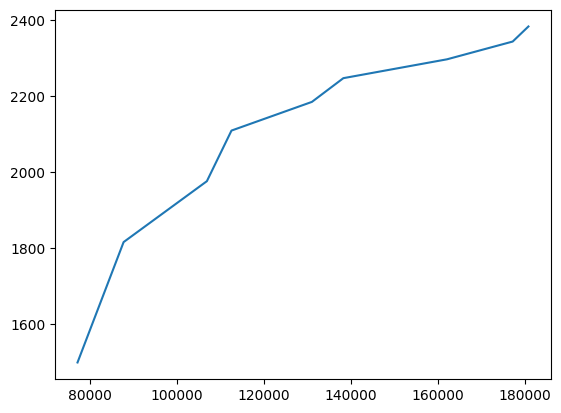

In [67]:
ikuinokkusu = tmp[tmp.horse == "イクイノックス"]
plt.plot(ikuinokkusu["horse_Glicko2"])
display(ikuinokkusu)

In [81]:
import pandas as pd
import numpy as np
from collections import defaultdict
from trueskill import TrueSkill, Rating # 必要なクラスをインポート

def calc_trueskill_fast(df_to_copy, feature_col, target_col, prefix):
    """
    TrueSkill計算を効率的なDataFrame操作で高速化したバージョン。
    """
    if (target_col is None) or (prefix is None):
        raise ValueError("target_col and prefix must be specified")

    df = df_to_copy.copy()
    
    # 元のfeature_colリストを変更しないように新しいリストを作成
    new_feature_col = feature_col.copy()

    CONFIDENCE_MULTIPLIER = 3

    # 新しく追加する列名を事前に定義
    ts_mu_col = f"{prefix}_TrueSkill"
    ts_sigma_col = f"{prefix}_TrueSkill_sigma"
    ts_min_col = f"{prefix}_TrueSkill_min"
    ts_max_col = f"{prefix}_TrueSkill_max"
    ts_after_col = f"{prefix}_TrueSkill_after_racing"
    
    # 新しい特徴量をリストに追加
    new_feature_col.extend([ts_mu_col, ts_sigma_col, ts_min_col, ts_max_col])

    # TrueSkill環境とレーティング辞書を初期化
    env = TrueSkill(draw_probability=0.0)
    ratings = defaultdict(lambda: env.create_rating())

    # 処理済みのグループを格納するリスト
    processed_groups = []
    
    # groupbyオブジェクトを作成（sort=Falseで元の順序を維持）
    grouped = df.groupby("id_for_fold", observed=True, sort=False)

    for race_id, group in grouped:
        # 各グループのコピーに対して変更を加える
        group_copy = group.copy()
        
        all_targets = group_copy[target_col]

        # --- 1. レース前TrueSkillを効率的に記録 ---
        # .map()とlambda式を使い、辞書からmuとsigmaの値を高速に取得
        mu_series = all_targets.map(lambda x: ratings[x].mu)
        sigma_series = all_targets.map(lambda x: ratings[x].sigma)

        # 取得したSeriesをDataFrameの列として一括で代入
        group_copy[ts_mu_col] = mu_series
        group_copy[ts_sigma_col] = sigma_series
        
        # min/maxをベクトル演算で効率的に計算
        group_copy[ts_min_col] = mu_series - sigma_series * CONFIDENCE_MULTIPLIER
        group_copy[ts_max_col] = mu_series + sigma_series * CONFIDENCE_MULTIPLIER

        # --- 2. TrueSkill計算とレーティング更新 ---
        # 正常なレースデータのみを対象
        race_data = group_copy[group_copy["error_code"] == 0]
        
        # 意味のあるレーティング更新は、通常2つ以上のエンティティが存在する場合
        if len(race_data) >= 2:
            target_list = race_data[target_col].tolist()
            # ratings辞書から現在のレーティングオブジェクトのリストを作成
            race_ratings = [[ratings[target]] for target in target_list]
            ranks = race_data["rank"].tolist()

            # TrueSkillライブラリで新しいレーティングを計算
            new_ratings = env.rate(race_ratings, ranks=ranks)

            # ratings辞書を新しいレーティングで更新
            for target, new_rating_tuple in zip(target_list, new_ratings):
                ratings[target] = new_rating_tuple[0]
        
        # --- 3. レース後TrueSkillを効率的に記録 ---
        # 更新後のratings辞書からmuの値を.map()で取得
        group_copy[ts_after_col] = all_targets.map(lambda x: ratings[x].mu)

        # 処理済みのグループをリストに追加
        processed_groups.append(group_copy)

    # --- 4. 最後に処理済みグループを一度に結合 ---
    # .sort_index()で元のDataFrameの順序を復元
    result_df = pd.concat(processed_groups).sort_values(by="datetime", ascending=True)

    return result_df, new_feature_col

In [82]:
tmp, _ = calc_trueskill_fast(df, [], target_col="horse", prefix="horse")

In [83]:
tmp.head()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,target,target3,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing
252634,202001050601010115,2020,1,5,1,中山,1,1,ラブカワールド,1177,1131,16,8,15,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,436.0,4.0,3,474.2,355.9,15,254.1,14,153.0,39.3,115.2,36.0,15,74.6,30.0,14,13,2.0,1153,NaN,NaN,15.0,16.0,39.9,9,35.4,38.7,40.57,36.0,1.5,後方,15.0,0,0,トゥザワールド,ラブカテリーナ,オレハマッテルゼ,ロイヤルチャージャー系,黒鹿,2017104350,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,0,0,25.0,8.333333,0.0,50.0,19.309743
252637,202001050601010111,2020,1,5,1,中山,1,1,コトブキノニ,1140,1035,16,6,11,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,482.0,18.0,3,392.6,313.6,14,258.2,15,137.8,35.4,95.2,29.7,14,78.9,31.7,15,16,2.9,1162,NaN,NaN,9.0,11.0,41.2,16,35.0,35.0,40.57,36.0,1.1,後方,14.0,0,0,エイシンアポロン,ヤマホトトギス,サクラプレジデント,ロイヤルチャージャー系,鹿毛,2017105743,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,0,0,25.0,8.333333,0.0,50.0,11.832068
252628,202001050601010114,2020,1,5,1,中山,1,1,エクメディノツルギ,422,1174,16,7,14,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,424.0,0.0,3,121.7,105.7,11,92.7,11,37.9,10.0,28.0,9.0,11,17.0,7.0,10,7,0.9,1142,NaN,NaN,6.0,8.0,39.6,7,34.6,37.4,40.57,36.0,0.7,中団,11.0,0,0,スクワートルスクワート,クサナギノツルギ,デュランダル,ロイヤルチャージャー系,鹿毛,2017109160,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,0,0,25.0,8.333333,0.0,50.0,26.742798
252622,202001050601010107,2020,1,5,1,中山,1,1,オイデヤスダイジン,1119,1132,16,4,7,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,460.0,2.0,3,3.6,4.2,2,3.8,2,2.6,1.1,2.7,1.3,2,2.3,1.3,2,1,-0.0,1133,NaN,NaN,5.0,5.0,38.9,3,34.4,38.4,40.57,36.0,0.5,中団,2.0,510,0,ヘニーヒューズ,ハロータマ,ゼンノエルシド,ニアークティック系,鹿毛,2017101464,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,1,1,25.0,8.333333,0.0,50.0,38.167932
252623,202001050601010101,2020,1,5,1,中山,1,1,グルアーブ,641,1163,16,1,1,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,432.0,4.0,3,17.2,16.1,5,15.4,4,7.2,2.2,5.6,2.1,4,4.4,2.0,4,2,0.0,1133,NaN,NaN,12.0,11.0,38.0,1,35.3,42.9,40.57,36.0,1.4,後方,5.0,200,0,トーセンラー,タニノジュレップ,コロナドズクエスト,ネイティヴダンサー系,鹿毛,2017103291,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,0,1,25.0,8.333333,0.0,50.0,34.579983


In [76]:
tmp.sort_values("horse_TrueSkill", ascending=False)[["year", "month", "day", "place", "horse", "horse_TrueSkill", "horse_TrueSkill_after_racing"]].head(20)

,year,month,day,place,horse,horse_TrueSkill,horse_TrueSkill_after_racing
147606,2022,4,3,阪神,エフフォーリア,51.754354,48.396737
160126,2021,12,26,中山,エフフォーリア,51.288338,51.754354
71709,2023,11,26,東京,イクイノックス,51.069069,51.950778
29742,2024,10,27,東京,リバティアイランド,51.057917,48.319996
186810,2021,5,23,東京,ソダシ,50.878951,48.032776
71710,2023,11,26,東京,リバティアイランド,50.769014,51.057917
75446,2023,10,29,東京,イクイノックス,50.379890,51.069069
167485,2021,10,31,東京,エフフォーリア,50.377197,51.288338
77410,2023,10,15,京都,リバティアイランド,49.817462,50.769014
90733,2023,6,25,阪神,イクイノックス,49.748247,50.379890


In [77]:
tmp[tmp["horse"] == "エフフォーリア"]

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,target,target3,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing
108014,202302120901021110,2023,2,12,1,阪神,2,11,エフフォーリア,1170,1097,13,7,10,179,17,4,2200,良,晴,14,牡,5,58.0,NaN,524.0,-8.0,2,3.3,3.5,2,4.0,2,1.8,1.3,2.0,1.5,2,2.0,1.5,1,0,----,----,2.0,2.0,2.0,3.0,NaN,0,NaN,NaN,55.37,54.8,NaN,NaN,2.0,0,4,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2023021209010211,芝,平地,R,阪神芝2200,outer,2023-02-12 11:03:00,over4,0,0,46.088262,1.733229,40.888577,51.287948,46.088262
114341,202212250605081107,2022,12,25,5,中山,8,11,エフフォーリア,1170,1097,16,4,7,195,17,5,2500,良,晴,13,牡,4,57.0,B,532.0,12.0,4,10.1,10.0,5,9.5,5,4.5,2.6,4.4,2.7,6,4.2,2.8,6,5,0.8,2332,5.0,5.0,4.0,3.0,36.3,6,36.92,51.7,54.57,52.5,0.4,先行,5.0,4000,0,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2022122506050811,芝,平地,R,中山芝2500,inner,2022-12-25 11:02:00,over4,0,0,46.766370,1.876857,41.135798,52.396943,46.088262
136946,202206260903041104,2022,6,26,3,阪神,4,11,エフフォーリア,1170,1097,18,2,4,195,17,4,2200,良,晴,13,牡,4,58.0,B,520.0,-2.0,4,3.3,3.5,1,3.8,1,2.1,1.6,2.3,1.8,2,2.3,1.8,1,6,0.9,2106,9.0,8.0,8.0,10.0,36.2,4,35.40,47.8,47.90,46.5,1.0,中団,1.0,0,0,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2022062609030411,芝,平地,R,阪神芝2200,inner,2022-06-26 11:03:00,over4,0,0,48.396737,2.063792,42.205361,54.588113,46.766370
147606,202204030902041106,2022,4,3,2,阪神,4,11,エフフォーリア,1170,1097,16,3,6,195,17,4,2000,良,曇,14,牡,4,57.0,NaN,522.0,6.0,4,1.5,1.5,1,1.7,1,1.1,1.1,1.1,1.1,1,1.2,1.1,1,9,0.7,1591,9.0,8.0,8.0,10.0,35.5,8,35.83,50.9,50.97,48.9,1.0,中団,1.0,0,0,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2022040309020411,芝,平地,R,阪神芝2000,inner,2022-04-03 11:03:00,over4,0,0,51.754354,2.329800,44.764954,58.743754,48.396737
160126,202112260605081110,2021,12,26,5,中山,8,11,エフフォーリア,1170,1097,16,5,10,195,17,5,2500,良,晴,13,牡,3,55.0,NaN,516.0,2.0,4,2.1,2.2,1,2.4,1,1.3,1.1,1.3,1.1,1,1.5,1.2,1,1,-0.1,2320,9.0,9.0,8.0,5.0,35.9,1,36.66,52.1,51.83,49.2,0.8,中団,1.0,30000,0,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2021122606050811,芝,平地,R,中山芝2500,outer,2021-12-26 11:02:00,3,1,1,51.288338,2.447881,43.944695,58.631981,51.754354
167485,202110310504081105,2021,10,31,4,東京,8,11,エフフォーリア,1170,1097,16,3,5,195,11,3,2000,良,曇,13,牡,3,56.0,NaN,514.0,4.0,4,3.4,3.5,3,3.8,3,1.8,1.2,1.8,1.2,2,1.5,1.2,1,1,-0.1,1579,NaN,6.0,6.0,6.0,33.2,3,36.30,59.3,58.87,57.5,0.4,中団,3.0,15000,0,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2021103105040811,芝,平地,L,東京芝2000,inner,2021-10-31 11:01:00,3,1,1,50.377197,2.616967,42.526297,58.228097,51.288338
185983,202105300502121101,2021,5,30,2,東京,C,11,エフフォーリア,1170,1097,17,1,1,195,11,4,2400,良,晴,12,牡,3,57.0,NaN,510.0,6.0,4,1.7,1.7,1,1.8,1,1.3,1.1,1.3,1.1,1,1.4,1.2,1,2,0.0,2225,3.0,4.0,9.0,9.0,33.4,1,36.37,58.9,58.97,56.8,0.5,中団,1.0,8000,0,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2021053005021211,芝,平地,L,東京芝2400,inner,2021-05-30 11:01:00,3,0,1,49.614402,3.087502,40.351895,58.876908,50.377197
191606,202104180603081107,2021,4,18,3,中山,8,11,エフフォーリア,1170,1097,16,4,7,195,17,4,2000,稍,晴,12,牡,3,57.0,NaN,504.0,-10.0,4,3.7,3.5,1,3.8,1,1.9,1.4,1.9,1.5,2,2.1,1.7,2,1,-0.5,2006,3.0,4.0,4.0,4.0,36.7,2,35.96,48.0,47.37,46.8,0.3,先行,2.0,11000,0,エピファネイア,ケイティーズハート,ハーツクライ,ロイヤルチャージャー系,鹿毛,2018105027,2021041806030811,芝,平地,R,中山芝2000,inner,2021-04-18 